# Statistics
As mentioned in the Probability lesson, Statistics is a closely related, yet distinct discipline from Probability.  In Probability, we were primarily interested in examining mathematical properties of random variables, whereas here, we'll be often drawing inferences from real-world data that has been modeled using the language of probability.

Data Science on the other hand, really ought to be considered a subfield of statistics.  The distinction is really a bit of an accident, as Data Science was born out of Big Data in which the statistical details tend to become irrelevant.  As a practicing Data Scientist, however, you must be comfortable with statistical concepts and jargon in order to read and understand the methods and literature in this field.  In this notebook, we'll just go over the essentials, including:

- Hypothesis Testing
  - z-test
  - Student's t-test
  - Multiple Hypotheses
- Parameter Estimation
- Confidence Intervals
- Bayesian Statistics

When formally studying statistics, you'll be frequently be asked to be *extremely* careful about your assumptions, as the quality of your inferences is entirely dependent on the quality of your assumptions.  This skill is something that the not statistically trained Data Scientist may not have often practiced, so when working through this section, always keep in mind what sort of assumptions you are making when applying a model to a phenomenon.

## Hypothesis Testing
Much of what lies in the domain of Classicial Statistics falls under what is referred to as *Hypothesis Testing*.  In most contexts, hypothesis testing means asking if our observed data is an indication of some structure, or just due to chance alone.  Is it a real effect or just a random fluke?

Consider for example, the question of whether or not a coin is fair.  One way to think about this, is to flip the coin many times, write down the results, and examine how closely it resembles the distribution of the fair coin.  We can do just that with

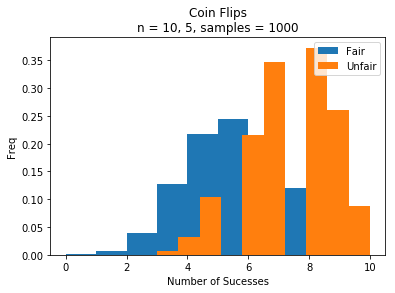

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
X_fair = np.random.binomial(n = 10, p = 0.5, size = 1000)
X_unfair = np.random.binomial(n = 10, p = 0.75, size = 1000)

plt.hist(X_fair, density = True, bins = 10, label = 'Fair')
plt.hist(X_unfair, density = True, bins = 10, label = 'Unfair')
plt.legend(loc = 'upper right')
plt.title('Coin Flips\nn = 10, 5, samples = 1000')
plt.xlabel('Number of Sucesses')
plt.ylabel('Freq')
plt.show()

We can see pretty quickly that the distributions are not the same, so if this came from real-world data, we could naively claim that the coin is probably unfair.  However, to employ power of statistics we need to quantify this intuition *exactly*, and this is done by making a very subtle yet, distinct assumption.  Namely, we do not ask "how likely is it that the coin is loaded given the data", but rather, "how likely is the data given that the coin is **not** loaded?".  The latter assumption is called the *null hypothesis*, and represents the hypothesis we will be testing.

The null hypothesis takes different forms in different contexts, but it always represents the assumption that no effect was observed: the medical treatment had no effect, reducing the speed limit did not reduce accidents, the coin is fair, etc...  In our example above of a fair coin flip, in the logic of hypothesis testing, we must ask the question, how likely is the data given that the coin is fair?

In a sequence of $10$ flips there are $2^{10} = 1024$ possible outcomes, all equally likely.  For a *fair coin*, there is only one way to get $10$ heads, and likewise, there are $10$ ways to get $9$ heads.  We could likewise, compute this for all possible combinations.  So if we flipped a coin 10 times, and got all heads, how likely is that observation from a fair coin?  The computation is simply

$$p = 1/1024 = 0.001$$

Or about one in a thousand, meaning that the probability that our coin is fair is very low.

Hypothesis testing in practice is a bit more complicated.  To test a hypothesis from a given dataset, we need some number, or statistic, on which to test our hypothesis.  Above the case was just the number of heads, but in practice it is often the mean or some other bit of information which can be extracted from the data for which the distribution is known under the null hypothesis.

Consider a distribution, of say, human heights in a well-fed population versus in a not well-fed population with the following data.

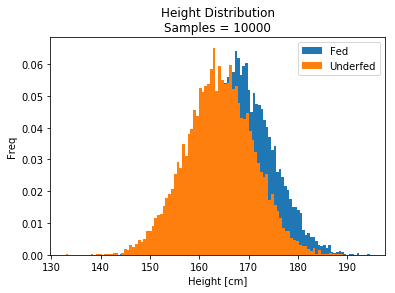

In [2]:
X_fed = 7*np.random.randn(10000)+168
X_underfed = 7*np.random.randn(10000)+164

plt.hist(X_fed, density = True, bins = 100, label = 'Fed')
plt.hist(X_underfed, density = True, bins = 100, label = 'Underfed')
plt.legend(loc = 'upper right')
plt.title('Height Distribution\nSamples = 10000')
plt.xlabel('Height [cm]')
plt.ylabel('Freq')
plt.show()

We can see that the distributions for each are slightly different, but what if we wanted to know how much different?  One way to compute this would be to find how much overlap there is between the two.

We can approach this problem with a couple of assumptions.
- Heights are normally distributed which appears reasonable given the data.
- If we assume they are normally distributed, then we can fit a normal distribution to each by computing the mean and variance.

In practice, you may want to perform some tests on the data to validate the normality assumption, but we'll just take it as a given here.  Computing the mean and variance of each yeilds.

In [3]:
mean_fed = X_fed.mean()
mean_underfed = X_underfed.mean()
var_fed = X_fed.var()
var_underfed = X_underfed.var()

print('Mean Fed: ' + str(mean_fed))
print('Var Fed: ' + str(var_fed))
print('Mean Underfed: ' + str(mean_underfed))
print('Var Underfed: ' + str(var_underfed))

Mean Fed: 167.90097432153138
Var Fed: 48.07583470572159
Mean Underfed: 164.07896753942143
Var Underfed: 48.24813678477664


We can see that the variances are close, but the mean is different.  The question we are interested in is whether or not this difference in mean is statistically significant.  To answer this question, we will assume a null hypothesis that the underfed data came from the same distribution as the fed data, since the fed population represents the population without the effect, and then compute the likelihood of observing that data.

We first must fit a normal distribution to each of the populations using the mean and variance computed above, yielding.

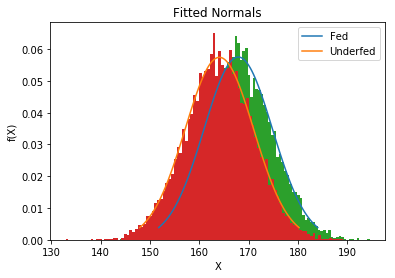

In [4]:
from scipy.stats import norm
# Fit normals
fed_norm = norm(loc = mean_fed, scale = np.sqrt(var_fed))
underfed_norm = norm(loc = mean_underfed, scale = np.sqrt(var_underfed))


X_n_fed = np.linspace(fed_norm.ppf(0.01), fed_norm.ppf(0.99), 100)
X_n_underfed = np.linspace(underfed_norm.ppf(0.01), underfed_norm.ppf(0.99), 100)
plt.plot(X_n_fed, fed_norm.pdf(X_n_fed), label = 'Fed')
plt.plot(X_n_underfed, underfed_norm.pdf(X_n_underfed), label = 'Underfed')
plt.hist(X_fed, density = True, bins = 100)
plt.hist(X_underfed, density = True, bins = 100)
plt.title('Fitted Normals')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend(loc = 'upper right')
plt.show()

As can be seen, the normal curves fitted to the data approximate it well.  Now as stated before, hypothesis testing is done by selecting a test statistic.  In our case, we are interested in whether or not malnourishment has a measurable effect on human height.  This is equivalent to asking whether or not the difference in mean between the two population is significant, and, as it turns out, the mean of heights (or any random variable for that matter) follows a normal distribution, making it a great candidate since it is both calculable from the data and the distribution is known.

As with all hypothesis testing, we must ask ourselves the likelihood of the data, given the null hypothesis.  To test this, we need a test statistic, and here we will use the `Z-Score` which can be computed as follows

$$Z = \frac{x - \mu}{\sigma}$$

where $x$ is our data point, $\mu$ is the mean as computed from the data, $\sigma$ is the standard deviation.  Doing so to our data, "scales" it so that it has mean 0 and variance 1.  This is a very common procedure throughout Data Science as many machine learning algorithms either require or perform better with Z-scaled data.  This can be done in `python` by

In [5]:
from scipy.stats import zscore
z_scores = zscore(X_fed)

But since we will be testing the mean, we need to use the standard error of the mean given by

$$SE = \frac{\sigma}{\sqrt{n}}$$

where $\sigma$ is the standard deviation and $n$ is the number of data points.

What we are interested in here is the *difference* between the means of the two populations.  Our Null Hypothesis is that this difference is 0 or

$$H_0: \mu_f - \mu_u = 0 \\
H_1: \mu_f - \mu_u > 0$$

where $H_0, H_1$ are our null and alternative hypothesis respectively, and likewise for the means denoted $\mu_f, \mu_u$ for the fed and underfed populations.  The question now becomes, is this difference statistically significant?  We can answer this question by asking *how likely is it to obtain a mean of $\mu_u$ given the distribution of the fed population?*.  Computing this is very straight forward -- we simply compute the `Z-Score` of the difference and then compute the associated probability of obtaining this result.

In [6]:
# Get the standard error
se = np.sqrt(var_fed)/np.sqrt(len(X_fed))

# First compute the z-score
z_score = (mean_fed - mean_underfed) / se

# Now compute the probability of obtaining such a z-score under the null hypothesis
p_value = 1 - norm.cdf(z_score)

print('Z-Score: ' + str(z_score))
print('p-value: ' + str(p_value))

Z-Score: 55.12238964946853
p-value: 0.0


The `p-value` we computed above is the probability of obtaining a `z-score` under the null hypothesis.  This is often denoted $\alpha$ in the literature and *typically* for values less than 0.05, we say that we can reject the null hypothesis.  Note that 0.05 is somewhat arbitrary and you may find use cases in which a larger alpha is more appropriate.  In our case, we have a `p-value` of less than 0.05 and therefore will reject the null hypothesis

### Student's t-test
What was demonstrated above is known as a `Z-test` since it makes use of the Z statistic.  When working with real-world data however, a statistician will often employ the Student's t-test for [various reasons](https://en.wikipedia.org/wiki/Student%27s_t-test), and as such, in most situations you may find yourself in as a Data Scientist, it is recommended that you do the same.

The primary difference between the z-test and t-test is the underlying distribution.  As stated before, hypothesis testing is done on statistics which are both easy to compute (most of the time) and whose distribution is known.  For the z-test, the distribution was the Normal and for the t-test it is the Student's t-distribution which looks very much like a normal except that it has a heavy tail and takes different parameters.

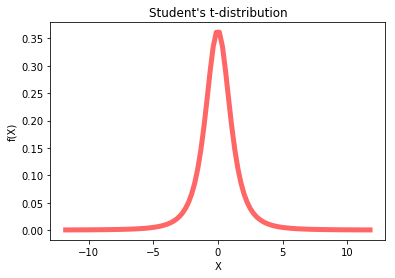

In [8]:
from scipy.stats import t
df = 2.74
X = np.linspace(t.ppf(0.001, df),t.ppf(0.999, df), 100)
plt.plot(X, t.pdf(X, df),'r-', lw=5, alpha=0.6, label='t pdf')
plt.title("Student's t-distribution")
plt.xlabel('X')
plt.ylabel('f(X)')
plt.show()

When making use of both the t-test and z-test we must keep in mind that one of the assumptions is that the variance of the null and alternative hypotheses.  There are ways around this assumption for which there are many alternatives in `scipy`, but we will continue to operate as if they are equal.

Performing a t-test is very easy, and can be done with the above data by

In [9]:
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(X_fed, X_underfed, equal_var = True)

print('t-statistic: ' + str(t_stat))
print('p-value: ' + str(p_value))

t-statistic: 38.94059179014731
p-value: 0.0


results of a t-test are intepreted the same as for the z-test -- a low p-value indicates that the null hypothesis can be rejected.

**Create a sample data set in which the means are very close and perform a z-test and t-test.  Are the results similar?**

In [10]:
# Create sample data
np.random.seed(0)
X_1 = np.random.randn(10000)
X_2 = X_1 + 0.025

# z-test
se = np.std(X_1)/np.sqrt(len(X_1))
z_score = (X_1.mean() - X_2.mean()) / se
p_value = norm.cdf(z_score)

print('Z-Score: ' + str(z_score))
print('p-value: ' + str(p_value))

Z-Score: -2.5315005545628124
p-value: 0.005678781892184168


In [11]:
# t-test
t_stat, p_value = ttest_ind(X_1, X_2, equal_var = True)

print('Z-Score: ' + str(t_stat))
print('p-value: ' + str(p_value))

Z-Score: -1.7899517044107716
p-value: 0.07347679977986502


*The results are somewhat similar, but for these particular values, we find that with one test we reject the null hypothesis with a p-value of less than 0.05 whereas for the t-test we fail to reject due to a p-value of greater than 0.5.*

## Parameter Estimation
The next topic to cover is something we have actually touched on previously without rigoursly explaining.  As you may have noticed before, when we computed our mean and variance above, we were actually only making estimates.  It is then from these estimates that we can fit a normal distribution or whatever else is needed.

It is impossible, for example, to determine the "real" mean human height (or any random variable for that matter), but we assume that it exists and we estimate accordingly.  These estimates are made by sampling from the population and computing the mean using

$$\hat{\mu} = \frac{1}{N}\sum{x_i}$$

Note that the "hat" denotes an estimated parameter and is seen throughout the statisics literature.  Now suppose that we took another same size sample from the population and again estimated the mean.  Our new value would be slightly different than the previous, indicating that our parameter estimates themselves have associated probability distributions.

We may then be interested in asking, how accurate is our estimate to the "true" mean?  There are a few ways to approach this, but here we will just touch on the two that come up frequently in Data Science, namely

- Consistency: An estimator $\hat{\mu}$ is "consistent" if it tends to approach the true value as the sample size increases.
- Bias: An estimated $\hat{\mu}$ is "unbiased" if $E[\hat{\mu}] = \alpha$ where a $\alpha$ is the true value.  In other words, if the mean value of the estimator is equal to the actual mean, then our estimator is unbiased.

Computing whether your estimator is consistent or unbiased is a mathematical exercise which you would explore in a formal statistics course.  But just for reference here, the estimates for the mean and variance of a sample given by

$$\hat{\mu} = \frac{1}{N}\sum{x_i}$$
$$\hat{\sigma} = \frac{1}{N}\sum{(x_i - \hat{\mu})^2}$$

and are both consistent.  However, the estimate for the variance *is* biased, as it can be shown to underestimate the true variance.  The correction for this is not very intuitive and is often demonstrated mathematically which we will omit.  In short, it occurs because we must use the least squares estimate for the mean which "costs" us one degree of freedom.  The unbiased correction is then

$$\hat{\sigma} = \frac{1}{N - 1}\sum{(x_i - \hat{\mu})^2}$$

Note that when working with most software packages, this will all be done for you under the hood, but it is good to understand that this is actually happening.

**Demonstrate that the sample variance as defined above is in fact a biased estimator by generating a random data set.**

In [12]:
# Function to compute mean
def get_mean(X):
    total = 0
    for x in X:
        total += x
    mean = total/len(X)
    return mean

def get_var(X, mean, biased = False):
    total = 0
    for x in X:
        total += (x - mean)**2
        
    if biased:
        var = total/len(X)
    else:
        var = total/(len(X) - 1)
    return var

# Generate data from a normal with mean 0 and variance 1
np.random.seed(1)
X = [np.random.randn(i) for i in range(2, 5000)]

# Compute sample mean and variance
X_means = [get_mean(x) for x in X]
X_vars = [get_var(x, mu, biased = True) for x, mu in zip(X, X_means)]
X_vars_un = [get_var(x, mu, biased = False) for x, mu in zip(X, X_means)]

# Calculate moving mean of both estimators
X_means_mov = [np.mean(X_means[:n]) for n in range(2, len(X_means))]
X_vars_mov = [np.mean(X_vars[:n]) for n in range(2, len(X_vars))]
X_vars_un_mov = [np.mean(X_vars_un[:n]) for n in range(2, len(X_vars_un))]

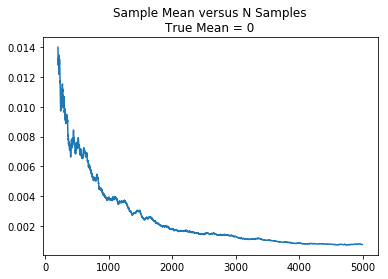

In [13]:
# Plot moving mean
plt.plot(np.arange(200, len(X_means_mov)), X_means_mov[200:])
plt.title('Sample Mean versus N Samples\nTrue Mean = 0')
plt.show()

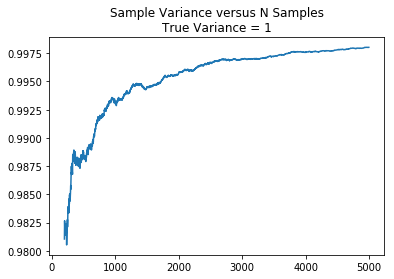

In [14]:
# Plot biased variance
plt.plot(np.arange(200, len(X_vars_mov)), X_vars_mov[200:])
plt.title('Sample Variance versus N Samples\nTrue Variance = 1')
plt.show()

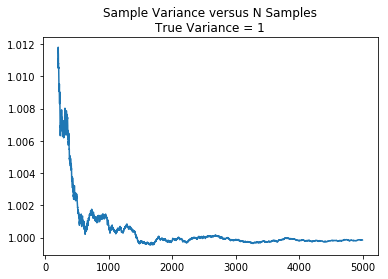

In [15]:
# Plot unbiased variance
plt.plot(np.arange(200, len(X_vars_un_mov)), X_vars_un_mov[200:])
plt.title('Sample Variance versus N Samples\nTrue Variance = 1')
plt.show()

*It appears that the mean has zeroed in on the true value whereas the variance is a bit below it.*

In [16]:
print('N = 100')
print('X Mean Estimator: ' + str(X_means[98]))
print('X Variance Biased Estimator: ' + str(X_vars[98]))
print('X Variance Unbiased Estimator: ' + str(X_vars_un[98]))

N = 100
X Mean Estimator: 0.0804947719616566
X Variance Biased Estimator: 0.9285372045420686
X Variance Unbiased Estimator: 0.9379163682243116


*Again, after 100 samples, we can see a difference between the biased and unbiased estimators.*

### Linear Regression
A topic we will touch on briefly in the context of parameter estimation is *linear regression*.  Suppose you have a dataset as follows.

In [1]:
# Generate data
x = -10 * np.random.random(100) + 10
y = (0.1*np.random.randn(100) + 1)*x + (0.1*np.random.randn(100) + 1)

# Plot
plt.scatter(x, y)
plt.title('Sample Data')
plt.xlabel('Independent Variable')
plt.ylabel('Response')
plt.show()

NameError: name 'np' is not defined

We can see that there is a general trend in our data of $y$ increasing with increasing $x$.  In statistics, $x$ is often referred to as your *feature* or *independent variable*, and $y$ is called the *dependent variable* or *response*.

A problem we are likely interested in answering is what is the relationship between the independent variable and response?  A first approach to this problem may be to fit a straight line to the data of the form

$$y = mx + b$$

Or stated with the statistics conventions

$$y = \beta_1 x_1 + \beta_0$$

Where y is the response, $x_1$ is our independent variable and $\beta_1$ and $\beta_0$ are our parameters.  Just as above, our task here is to estimate these two parameters from the data.  Additionally, we would like our parameters, if possible, to be both consistent and unbiased.  We can approach this problem by considering the square residuals, or the square of the difference between our predicted data points rom our model and the actual data point.  Stated mathematically we need to minimize

$$\sum{\epsilon}^2 = \sum{\left(y_i - \hat{\beta}_1 x_1 - \hat{\beta}_0\right)^2}$$

There are numerous ways to solve this which we shall omit here and state only the result.

$$\hat{\beta}_0 = \bar y - \hat{\beta}_1 \bar x$$

$$\hat{\beta}_1 = \frac{ \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) }{ \sum_{i=1}^n (x_i - \bar{x})^2 }$$

Where $\bar x$ and $\bar y$ are the means of $x$ and $y$.  The above unbiased estimator is known as the *Least Squares Estimator* and although simple, it appears often when working with model building problems.

Now that we can estimate the required parameters, we can fit a line to our data!

In [18]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
lm = OLS(y, add_constant(x))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     2516.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           1.09e-71
Time:                        12:51:57   Log-Likelihood:                -90.487
No. Observations:                 100   AIC:                             185.0
Df Residuals:                      98   BIC:                             190.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0540      0.119      8.869      0.000       0.818       1.290
x1             0.9988      0.020     50.156      0.000       0.959       1.038
==============================================================================
Omnibus:                        1.782   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.410   Jarque-Bera (JB):                1.218
Skew:                          -0.169   Prob(JB):                        0.544
Kurtosis:                       3.423   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And plot it

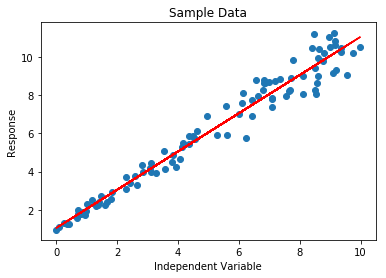

In [19]:
y_fit = np.sum(results.params * add_constant(x), axis = 1)
plt.scatter(x, y)
plt.plot(x, y_fit, color = 'red')
plt.title('Sample Data')
plt.xlabel('Independent Variable')
plt.ylabel('Response')
plt.show()

Note that we had to add the constant term to our data before performing the regression as `statsmodels` does not do so automatically.  The table is mostly statistics telling us the quality of our fit.  Of interest is the R-Squared value, also called the Coefficient of Determination, which is a very naive way of telling us how well our data is fit.  An R-Squared of 1 is a perfect fit and an R-Squared of 0 is no fit at all.  What value of R-Squared is acceptable varies significantly from problem to problem and discipline to discipline so there is no real rule of thumb.  Also of interest is the `std err`, or standard error, of each of our explanatory variables along with their associated `t` statistics and p-values.  These in short tell you how likely it is that each of your variables are important to your model, accepting only those with small p-values.

**Fit a linear regression model to the data below and comment on your results.**

In [20]:
np.random.seed(0)
X = np.random.rand(100)
y = np.random.rand(100)

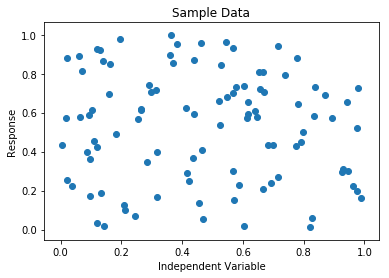

In [21]:
# Plot
plt.scatter(X, y)
plt.title('Sample Data')
plt.xlabel('Independent Variable')
plt.ylabel('Response')
plt.show()

In [22]:
# Fit a regression model
lm = OLS(y, add_constant(X))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.4302
Date:                Sat, 24 Feb 2018   Prob (F-statistic):              0.513
Time:                        12:51:57   Log-Likelihood:                -13.196
No. Observations:                 100   AIC:                             30.39
Df Residuals:                      98   BIC:                             35.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5581      0.054     10.417      0.000       0.452       0.664
x1            -0.0634      0.097     -0.656      0.513      -0.255       0.129
==============================================================================
Omnibus:                       19.276   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.354
Skew:                          -0.191   Prob(JB):                       0.0688
Kurtosis:                       1.933   Cond. No.                         4.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

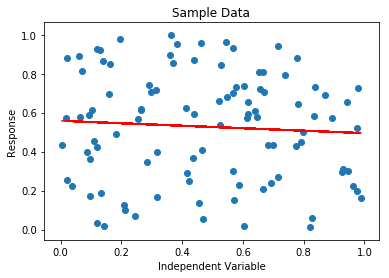

In [23]:
# And plot
y_fit = np.sum(results.params * add_constant(X), axis = 1)
plt.scatter(X, y)
plt.plot(X, y_fit, color = 'red')
plt.title('Sample Data')
plt.xlabel('Independent Variable')
plt.ylabel('Response')
plt.show()

Our fit here is pretty bad considering the low R-Squared value, p-value of the t statistic, and by visual inspection.  Since our data was fundamentally random with no structure, this is exactly what we should expect.

## Confidence Intervals
As has been said before, estimators are only estimates of the "true" value, and as such, we would like to be able to say something about the probability that the true value is within some interval.  Most commonly, cofidence intervals are found in mean calculations such as $\hat{\mu} = 1.3 \pm 0.2$ where $1.3$ is the computed mean and $0.2$ is a confidence interval referred to as the standard error of the mean (*SEM*).  We can compute the *SEM* by

$$SEM = \frac{\sigma}{\sqrt{n}}$$

where $\sigma$ is the population mean, and $n$ is the number of samples.  There are also built-in python functions to do the same

In [25]:
from scipy.stats import sem
X = np.random.randn(1000)
X_mean = X.mean()
X_sem = sem(X)

print('Mean X: ' + str(X_mean) + ' +/- ' + str(X_sem))

Mean X: 0.004379028822487808 +/- 0.031083263432154753


Which tells us that there is an $z$ significance that the true mean lies on the interval given by

$$[\hat{\mu}-z*SEM, \hat{\mu}+z*SEM]$$

Where the $z$ (sometimes denoted $\alpha$) represents the significance level and can be looked up in a z-score table.  Often 95% confidence is used which corresponds to $z = 1.96$.

As was emphasized in the beginning of this notebook, statisticians must always be very careful with their assumptions.  When building a confidence interval, we are essentially assuming that our mean is normally distributed, which by the mean value theorem is not a bad assumption given a large amount of data, and then computing the range over which the "middle" 95% of the resulting normal distribution lies.  Graphically this is

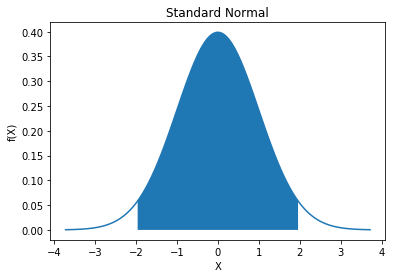

In [30]:
X = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100)
X_fill = np.linspace(-1.96, 1.96, 100)
plt.plot(X, norm.pdf(X))
plt.fill_between(X_fill, norm.pdf(X_fill))
plt.title('Standard Normal')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.show()

Where the shaded region represents the 95% confidence interval of the mean centered at $x = 0$ and variance standardized to $\sigma = 1$.  We can compute the confidence interval with

In [32]:
norm.interval(0.95)

(-1.959963984540054, 1.959963984540054)

Which shows us the interval for the standard normal.

**Compute the 98% confidence interval for the mean of a randomly generated dataset of mean not equal to 0, using the functions above, verifying by hand.**

In [91]:
# Generate random data
np.random.seed(0)
X = np.random.randn(1000) + 25
X_mean = X.mean()
X_sem = sem(X)

# Compute 98% C.I.
norm.interval(0.98, loc = X_mean, scale = X_sem)

(24.88209529349801, 25.027391291521596)

In [92]:
# Now By hand
X_std = X.std()
X_sem = X_std/np.sqrt(len(X))
(X_mean - 2.326*X_sem, X_mean + 2.326*X_sem)

(24.88214248468125, 25.027344100338357)

### Prior and Posterior Distributions

The above example demonstrates the kind of reasoning involved with Bayesian Inference, but doesn't really capture its true power.  For that we will need to introduce the idea of a *posterior distribution* which is nothing more than our prior distribution updated via Bayes' Theorem.  When performing real Bayesian Inference, one must be very careful in the choice of a prior, as some are "good" to work with while others are near impossible.

Choosing a good prior essentially means choosing one for which computing the likelihood function is easy given the information available to use.  The best cases are called *conjugate priors* in which updating the prior to the posterior is a very straight forward calculation.

To demonstrate this, consider the problem of determining the mean from a sample population for which the variance is known.  Now we know by the mean value theorem, that with enough samples, the mean will be normally distributed.  Under the Frequentest approach, we would start with assumption, fit a normal distribution to the data, and compute some confidence intervals if we'd like.  However, the Bayesian approach would be somewhat different.  Let's assume that the parameter we want to estimate, $\mu$ is normally distributed with known variance $\sigma^2$.  By [looking up a table of conjugate priors for the normal distribution](https://en.wikipedia.org/wiki/Conjugate_prior).  When choosing a good prior, often Bayes' Theorem reduces to the much simpler form of

$$P(A\mid B) = P(B \mid A) \, P(A)$$

which can be updated sequentially.  For the case of a normal prior, we see that it has the closed form solution

$$\begin{align}
E(\mu' \mid x) &= \frac{\sigma^2\mu + \sigma^2_0 x}{\sigma^2 + \sigma^2_0} \\[7pt]
\mathrm{Var}(\mu' \mid x) &= \frac{\sigma^2 \sigma^2_0}{\sigma^2 + \sigma^2_0}
\end{align}$$

where $\sigma_0$ is the known variance and all others are computed using the best parameters from the last update.  Note that we must first make a "guess" for the initial choice of parameters with our prior.  Results below for estimating the distribution for the standard normal

**Assuming that about 80% of women have long hair and that 15% men do, compute the probability of selecting a female given that the person has long hair as above.**

In [2]:
P_lh_f = 0.8
P_lh = (0.8+0.15)*0.5

P_f_lh = (0.5)*P_lh_f/P_lh

print('P(Female | LongHair) = ' + str(P_f_lh))

P(Female | LongHair) = 0.8421052631578947


### Prior and Posterior Distributions

The above example demonstrates the kind of reasoning involved with Bayesian Inference, but doesn't really capture its true power.  For that we will need to introduce the idea of a *posterior distribution* which is nothing more than our prior distribution updated via Bayes' Theorem.  When performing real Bayesian Inference, one must be very careful in the choice of a prior, as some are "good" to work with while others are near impossible.

Choosing a good prior essentially means choosing one for which computing the likelihood function is easy given the information available to use.  The best cases are called *conjugate priors* in which updating the prior to the posterior is a very straight forward calculation.

To demonstrate this, consider the problem of determining the mean from a sample population for which the variance is known.  Now we know by the mean value theorem, that with enough samples, the mean will be normally distributed.  Under the Frequentest approach, we would start with assumption, fit a normal distribution to the data, and compute some confidence intervals if we'd like.  However, the Bayesian approach would be somewhat different.  Let's assume that the parameter we want to estimate, $\mu$ is normally distributed with known variance $\sigma^2$.  By [looking up a table of conjugate priors for the normal distribution](https://en.wikipedia.org/wiki/Conjugate_prior).  When choosing a good prior, often Bayes' Theorem reduces to the much simpler form of

$$P(A\mid B) = P(B \mid A) \, P(A)$$

which can be updated sequentially.  For the case of a normal prior, we see that it has the closed form solution

$$\begin{align}
E(\mu' \mid x) &= \frac{\sigma^2\mu + \sigma^2_0 x}{\sigma^2 + \sigma^2_0} \\[7pt]
\mathrm{Var}(\mu' \mid x) &= \frac{\sigma^2 \sigma^2_0}{\sigma^2 + \sigma^2_0}
\end{align}$$

where $\sigma_0$ is the known variance and all others are computed using the best parameters from the last update.  Note that we must first make a "guess" for the initial choice of parameters with our prior.  Results below for estimating the distribution for the standard normal

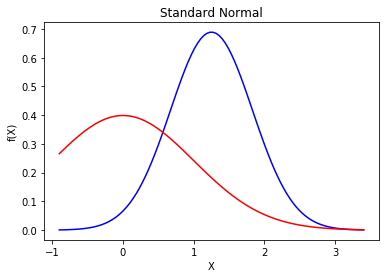

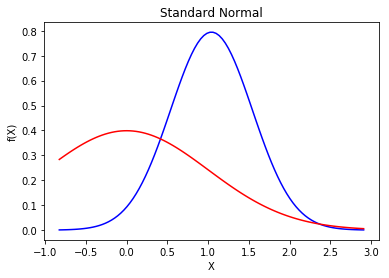

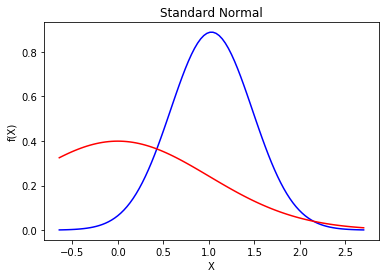

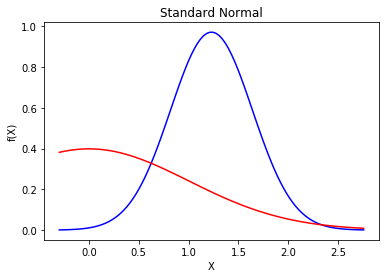

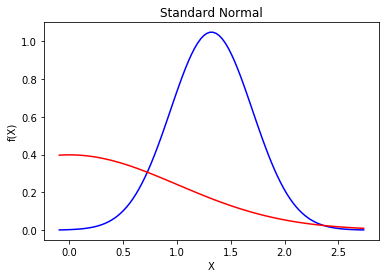

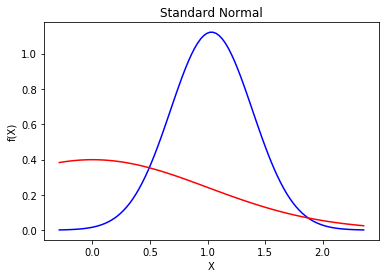

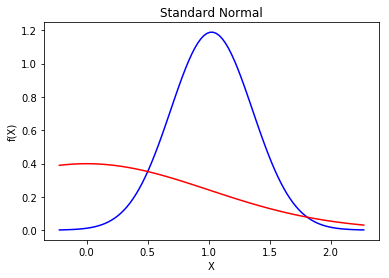

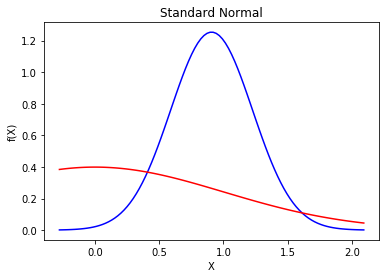

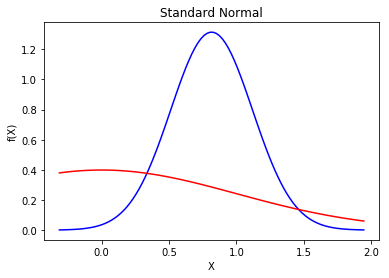

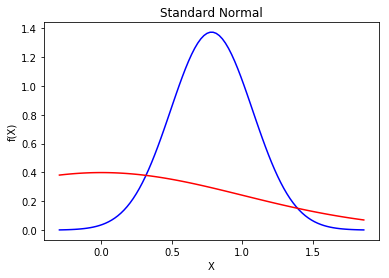

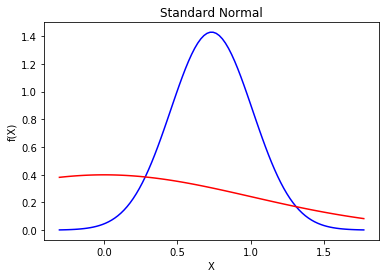

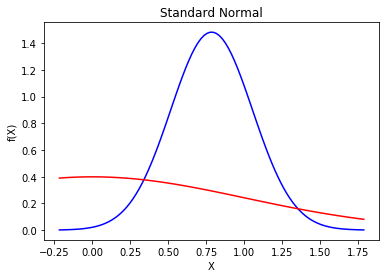

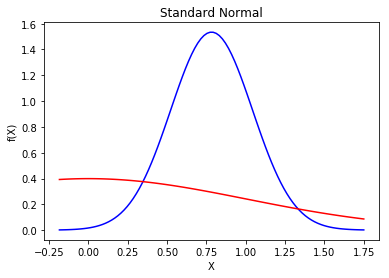

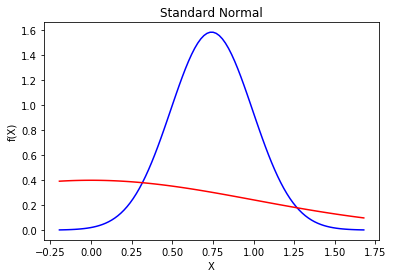

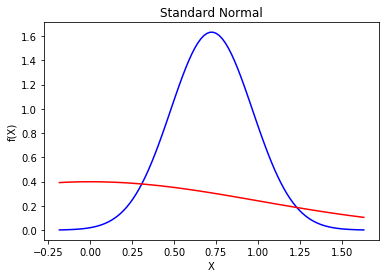

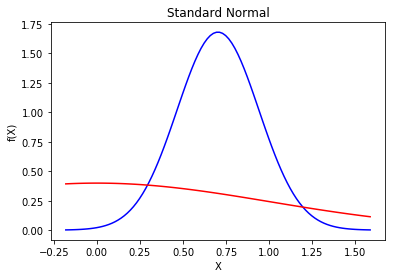

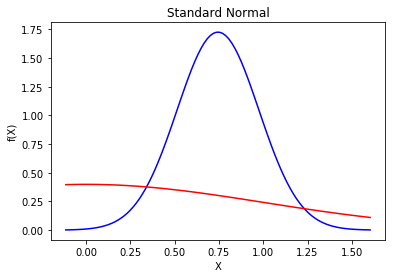

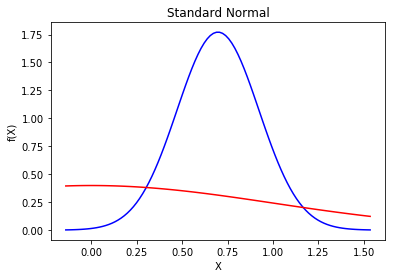

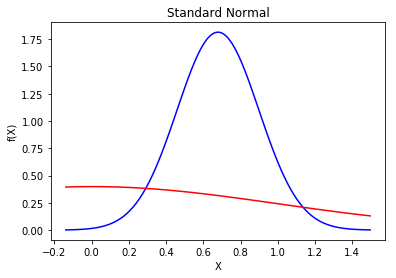

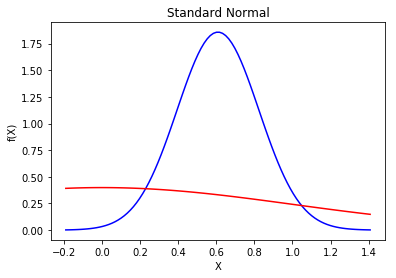

In [21]:
np.random.seed(0)
X = np.random.randn(100)
X_var = X.var()

X_mean_i = 1
X_var_i = 0.5

for n in range(20):
    X_mean_i = (X_var*X_mean_i + X_var_i*X[n]) / (X_var_i + X_var)
    X_var_i = (X_var_i*X_var) / (X_var_i + X_var)
    
    norm_new = norm(loc = X_mean_i, scale = np.sqrt(X_var_i))
    
    X_line = np.linspace(norm_new.ppf(0.0001), norm_new.ppf(0.9999), 100)
    
    plt.plot(X_line, norm_new.pdf(X_line), color = 'blue', label = 'New Normal')
    plt.plot(X_line, norm.pdf(X_line), color = 'red', label = 'True Normal')
    
    plt.title('Standard Normal')
    plt.xlabel('X')
    plt.ylabel('f(X)')
    plt.show()

As can be seen, the Bayesian estimate of the mean slowly moves toward the actual value as the number of samples increases.  After enough time, the classical and Bayesian approaches will reach the same conclusion, but depending on your use case and field, one is often preferred to the other, and of course, in the broader context of Data Science, it is important to at least understand what is happening here in principle.